In [129]:
import glob
import gsw
import warnings
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import os
import zarr
import matplotlib.colors as mcolors

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    lon          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    max_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    min_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    raising      (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    salinity     (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    temperature  (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    time         (trajectory, obs) datetime64[ns] 196kB dask.array<chunk

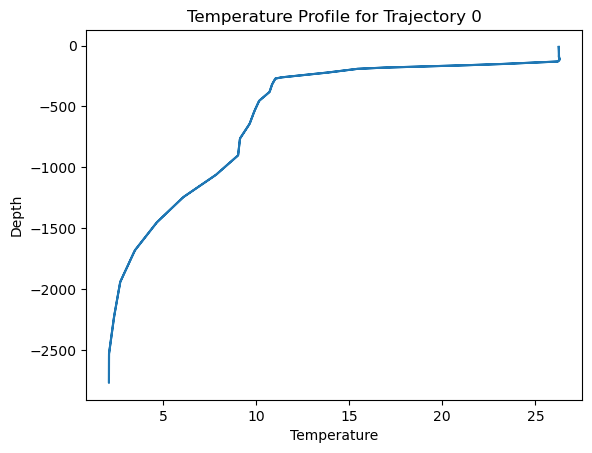

{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:12:00'), 'temperature': 26.256418228149414, 'salinity': 34.966346740722656, 'z': -11.0, 'trajectory': 38, 'obs': 0}


In [88]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Open the Zarr dataset
datadir = r"C:\Users\gvp63\Downloads\results (2)\somalia\results\ctd.zarr"
ds = xr.open_zarr(datadir)

# Inspect dataset
print(ds)

# Count the number of trajectories and observations
num_trajectories = ds.sizes['trajectory']
num_observations = ds.sizes['obs']
print(f"Number of trajectories: {num_trajectories}")
print(f"Number of observations per trajectory: {num_observations}")

# Plot temperature vs depth for the first trajectory
plt.plot(ds['temperature'].isel(trajectory=0), ds['z'].isel(trajectory=0))
plt.xlabel('Temperature')
plt.ylabel('Depth')
plt.title('Temperature Profile for Trajectory 0')
plt.show()

# Reshape dataset to avoid looping
ds_stacked = ds.stack(points=("trajectory", "obs")).reset_index("points")

# Convert to a dictionary efficiently
df = ds_stacked[['lat', 'lon', 'time', 'temperature', 'salinity', 'z']].to_dataframe()
df = df.reset_index(drop=True)  # Drop unnecessary index columns
data = df.to_dict(orient='records')

# Check the first profile
print(data[0])


In [89]:
print(data[80])
print(data[100])
print(data[150])
print(data[220])
print(data[300])
print(data[400])

{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:25:20'), 'temperature': 9.099099159240723, 'salinity': 35.17838668823242, 'z': -811.0, 'trajectory': 38, 'obs': 80}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:28:40'), 'temperature': 8.224143981933594, 'salinity': 35.172183990478516, 'z': -1011.0, 'trajectory': 38, 'obs': 100}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:37:00'), 'temperature': 4.367069721221924, 'salinity': 34.9659538269043, 'z': -1511.0, 'trajectory': 38, 'obs': 150}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:48:40'), 'temperature': 2.3896257877349854, 'salinity': 34.760215759277344, 'z': -2211.0, 'trajectory': 38, 'obs': 220}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-18 00:02:00'), 'temperature': 2.102433443069458, 'salinity': 34.77864074707031, 'z': -2531.0, 'traj

c:\Users\gvp63\anaconda3\envs\dyoc\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


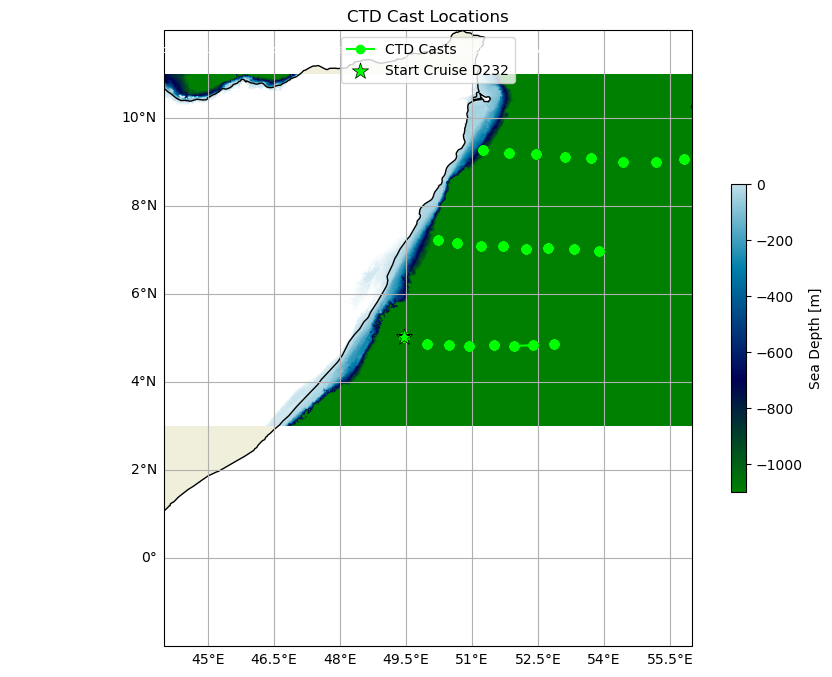

In [90]:
# Load bathymetry data
bathy = xr.open_dataset(r"C:\Users\gvp63\Downloads\gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot bathymetry
tp = ax.pcolormesh(bathy.lon, bathy.lat, bathy.elevation, cmap='ocean', vmin=-1100, vmax=100, transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.gridlines(draw_labels=['left', 'bottom'], zorder=0)

# Plot CTD cast locations
if data:
    ax.plot([profile['lon'] for profile in data], [profile['lat'] for profile in data], '-o',
            transform=ccrs.PlateCarree(), c='lime', label='CTD Casts')
    ax.scatter(data[0]['lon'], data[0]['lat'], c='lime', marker='*', s=150, zorder=2,
               transform=ccrs.PlateCarree(), edgecolors='k', linewidths=.5, label='Start Cruise D232')
    ax.legend(loc='upper center')
else:
    print("Warning: No CTD data found. Skipping CTD cast locations.")

# Set title and extent
ax.set_title('CTD Cast Locations')
ax.set_extent([44, 56, -2, 12])  # [min_lon, max_lon, min_lat, max_lat]

# Add colorbar
cb = fig.colorbar(tp, ax=ax, shrink=.5)
cb.ax.set_ylim([-1100, 0])
cb.set_label('Sea Depth [m]')

info_text = bathy.attrs.get('title', 'GEBCO 2024 Grid')  # Use 'title' or another available attribute
_ = ax.text(40.5, 11.5, info_text, c='w', fontsize=8)  # Adjust position as needed

plt.show()

In [91]:
# Constants
alpha_T = 1e-4  # Thermal expansion coefficient
beta_S = 7e-4   # Haline contraction coefficient
dens0 = 1027    # Reference density (kg/m³)
def calc_density(profile, plot=False):
    """
    Calculate density from a profile containing salinity, temperature, and depth.
    
    Parameters:
        profile (dict): A dictionary containing 'salinity', 'temperature', 'z', and 'trajectory'.
    """
    S = profile['salinity']
    T = profile['temperature']
    depth = profile['z']

    # Reference salinity and temperature (surface value)
    S0 = S[0]
    T0 = T[0]

    # Calculate density
    dens = dens0 * (1 - (alpha_T * (T - T0)) + (beta_S * (S - S0)))

    # Plot
    if plot==True:
        plt.figure(figsize=(8, 6))
        plt.plot(dens, -depth, 'o-', label=f"Trajectory {profile['trajectory']}")
        plt.xlabel('Density (kg/m³)')
        plt.ylabel('Depth (m)')
        plt.title('Density Profile')
        plt.grid()
        plt.legend()
        plt.show()

    return dens

In [92]:
from collections import defaultdict

# Group data points by trajectory
grouped_data = defaultdict(list)
for obs in data:
    trajectory = obs['trajectory']
    grouped_data[trajectory].append(obs)

# Convert to a list of profiles (each profile is a trajectory with multiple depth levels)
profiles = []
for trajectory, observations in grouped_data.items():
    # Extract valid (non-NaN) observations
    valid_obs = [
        obs for obs in observations
        if not (np.isnan(obs['salinity']) or 
                np.isnan(obs['temperature']) or 
                np.isnan(obs['z']))
    ]
    
    if not valid_obs:
        continue  # Skip trajectories with no valid data
    
    # Extract salinity, temperature, and depth from valid observations
    salinity = np.array([obs['salinity'] for obs in valid_obs])
    temperature = np.array([obs['temperature'] for obs in valid_obs])
    z = np.array([obs['z'] for obs in valid_obs])
    
    # Create a temporary profile dictionary to calculate density
    temp_profile = {
        'trajectory': trajectory,
        'salinity': salinity,
        'temperature': temperature,
        'z': z
    }
    
    # Calculate density
    dens = calc_density(temp_profile, plot=False)
    
    # Append the profile to the profiles list, including the calculated density
    profiles.append({
        'trajectory': trajectory,
        'density': dens,
        'salinity': salinity,
        'temperature': temperature,
        'z': z,
        'lat': valid_obs[0]['lat'],
        'lon': valid_obs[0]['lon'],
        'time': valid_obs[0]['time'],
        'transect_id': 3 if valid_obs[0]['lat'] > 8 else 2 if valid_obs[0]['lat'] > 6 else 1
    })

# Print the first profile to check
print(profiles[0])




{'trajectory': 38, 'density': array([1027.        , 1027.00277804, 1027.00820483, 1027.01521926,
       1027.02155966, 1027.02847811, 1027.03830232, 1027.06341003,
       1027.11699802, 1027.14660756, 1027.1731564 , 1027.20380765,
       1027.2387909 , 1027.39947551, 1027.56015993, 1027.73621111,
       1027.92674836, 1028.11729776, 1028.23141921, 1028.26515427,
       1028.29888454, 1028.33261001, 1028.38423523, 1028.43895709,
       1028.49367425, 1028.54838975, 1028.57659607, 1028.57786354,
       1028.57913268, 1028.58040083, 1028.58167075, 1028.58319307,
       1028.58533164, 1028.58747031, 1028.58961192, 1028.59175372,
       1028.59389288, 1028.59697327, 1028.61106786, 1028.62516245,
       1028.63925723, 1028.65335231, 1028.66745013, 1028.68154551,
       1028.69564362, 1028.70530289, 1028.71312173, 1028.72094341,
       1028.72876499, 1028.73658402, 1028.74440844, 1028.75223295,
       1028.76005482, 1028.76787944, 1028.77596458, 1028.78404992,
       1028.79213525, 1028.80021

In [93]:
data

[{'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:00'),
  'temperature': 26.256418228149414,
  'salinity': 34.966346740722656,
  'z': -11.0,
  'trajectory': 38,
  'obs': 0},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:10'),
  'temperature': 26.260557174682617,
  'salinity': 34.970802307128906,
  'z': -21.0,
  'trajectory': 38,
  'obs': 1},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:20'),
  'temperature': 26.26323127746582,
  'salinity': 34.97873306274414,
  'z': -31.0,
  'trajectory': 38,
  'obs': 2},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:30'),
  'temperature': 26.26406478881836,
  'salinity': 34.988609313964844,
  'z': -41.0,
  'trajectory': 38,
  'obs': 3},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:40'),
  'temperature': 26.265293

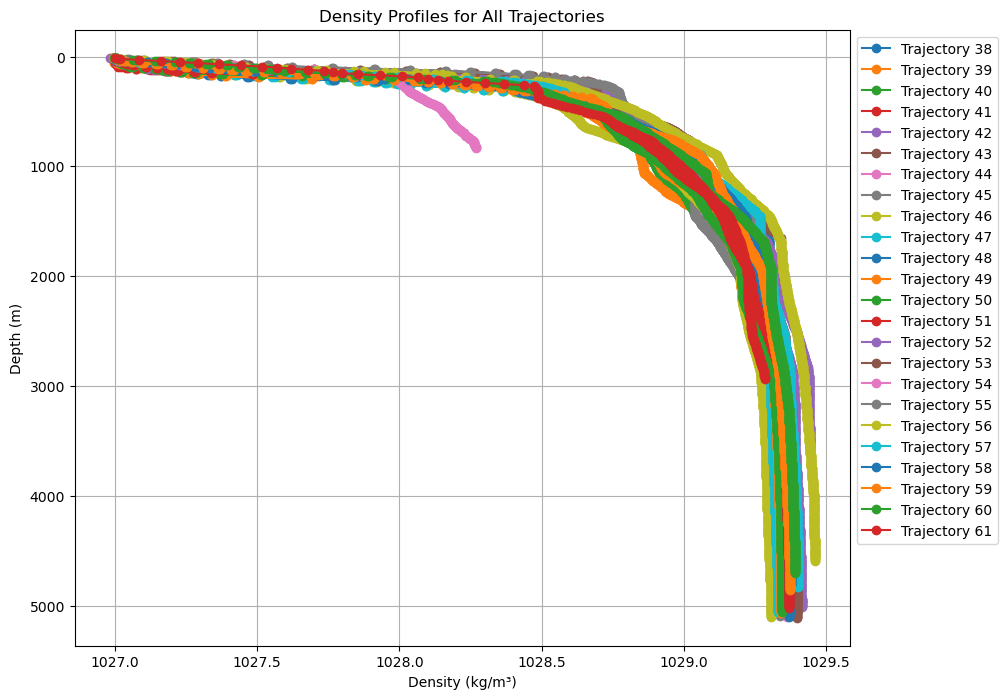

In [94]:
plt.figure(figsize=(10, 8))

for profile in profiles:
    dens = calc_density(profile, plot=False)
    depth = profile['z']
    plt.plot(dens, -depth, 'o-', label=f"Trajectory {profile['trajectory']}")

plt.xlabel('Density (kg/m³)')
plt.ylabel('Depth (m)')
plt.title('Density Profiles for All Trajectories')
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.gca().invert_yaxis()

# Save the plot
plt.savefig('density_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

In [95]:
# Constants
g = 9.81  # m/s²
rho0 = 1027  # kg/m³
f = 1e-4  # Coriolis parameter (adjust using f = 2Ωsin(latitude))
dx = 1e4  # Distance between stations (meters). Adjust based on your data!

# Group data by trajectory (assuming each trajectory is a station along the transect)
grouped_data = defaultdict(list)
for obs in data:
    trajectory = obs['trajectory']
    grouped_data[trajectory].append(obs)

# Sort trajectories to ensure correct station order (critical for gradients)
sorted_trajectories = sorted(grouped_data.keys())
profiles = []
for trajectory in sorted_trajectories:
    observations = grouped_data[trajectory]
    # Sort observations by depth (ascending)
    observations_sorted = sorted(observations, key=lambda x: x['z'])
    # Extract valid data (remove NaNs)
    valid_obs = [
        obs for obs in observations_sorted
        if not (np.isnan(obs['salinity']) or np.isnan(obs['temperature']) or np.isnan(obs['z']))
    ]
    if not valid_obs:
        continue
    # Calculate density for the profile
    salinity = np.array([obs['salinity'] for obs in valid_obs])
    temperature = np.array([obs['temperature'] for obs in valid_obs])
    z = np.array([obs['z'] for obs in valid_obs])
    dens = 1027 * (1 - 1e-4 * (temperature - temperature[0]) + 7e-4 * (salinity - salinity[0]))
    profiles.append({
        'trajectory': trajectory,
        'density': dens,
        'salinity': salinity,
        'temperature': temperature,
        'depth': z,
        'lat': valid_obs[0]['lat'],
        'lon': valid_obs[0]['lon'],
        'time': valid_obs[0]['time'],
        'transect_id': 3 if valid_obs[0]['lat'] > 8 else 2 if valid_obs[0]['lat'] > 6 else 1
    })

In [96]:
print(profiles[4]['depth'])

[-5011. -5001. -5001. ...   -21.   -11.   -11.]


In [97]:
# Extract density and depth arrays for all stations
density_profiles = [profile['density'] for profile in profiles]
depth_profiles = [profile['depth'] for profile in profiles]

# Ensure all profiles have the same depth levels (interpolate if necessary)
# Example: Interpolate to a common depth grid (adjust resolution as needed)
common_depth = np.linspace(np.min([np.min(z) for z in depth_profiles]), 
                           np.max([np.max(z) for z in depth_profiles]), 
                           100)
density_interp = []
for dens, z in zip(density_profiles, depth_profiles):
    dens_interp = np.interp(common_depth, z, dens)
    density_interp.append(dens_interp)

density_interp = np.array(density_interp)  # Shape: (n_stations, n_depth_levels)



In [98]:
# Integrate velocity over depth at each station
transport_per_station = np.trapz(u, x=common_depth, axis=1)  # Units: m²/s
#distance between stations..
from geopy.distance import geodesic

# Compute dx dynamically using geodesic distance
dx_list = []
for i in range(1, len(profiles)):  
    lat1, lon1 = profiles[i-1]['lat'], profiles[i-1]['lon']
    lat2, lon2 = profiles[i]['lat'], profiles[i]['lon']
    dx = geodesic((lat1, lon1), (lat2, lon2)).meters
    dx_list.append(dx)

dx_array = np.array(dx_list)

# Ensure dx_array length is one less than the number of stations
if len(dx_array) != len(profiles) - 1:
    raise ValueError(f"dx_array length {len(dx_array)} does not match station count {len(profiles) - 1}")

# Compute transport per station
transport_per_station = np.trapz(u, x=common_depth, axis=1)  # Units: m²/s

# Integrate across the transect using correct dx spacing
x_transect = np.insert(np.cumsum(dx_array), 0, 0)  # Ensure it matches transport_per_station

if len(transport_per_station) != len(x_transect):
    raise ValueError(f"Mismatch: transport_per_station has {len(transport_per_station)} elements, but x_transect has {len(x_transect)}.")

total_transport = np.trapz(transport_per_station, x=x_transect)  # Units: m³/s

print(f"Total volume transport: {total_transport:.2f} m³/s")

""" 
# Adjust plot scaling by using actual station distances
X, Z = np.meshgrid(np.insert(np.cumsum(dx_array), 0, 0), common_depth)
plt.figure(figsize=(10, 6))
plt.pcolormesh(X, Z, u.T, cmap='RdBu', shading='auto')
plt.colorbar(label='Velocity (m/s)')
plt.title('Geostrophic Velocity Section with Scaled Station Distances')
plt.xlabel('Distance Along Transect (m)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.show()
"""

Total volume transport: 168222336.28 m³/s


C:\Users\gvp63\AppData\Local\Temp\ipykernel_9524\4141666646.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u, x=common_depth, axis=1)  # Units: m²/s
C:\Users\gvp63\AppData\Local\Temp\ipykernel_9524\4141666646.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u, x=common_depth, axis=1)  # Units: m²/s
C:\Users\gvp63\AppData\Local\Temp\ipykernel_9524\4141666646.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_transport = np.trapz(transport_per_station, x=x_transect)  # Units: m³/s


" \n# Adjust plot scaling by using actual station distances\nX, Z = np.meshgrid(np.insert(np.cumsum(dx_array), 0, 0), common_depth)\nplt.figure(figsize=(10, 6))\nplt.pcolormesh(X, Z, u.T, cmap='RdBu', shading='auto')\nplt.colorbar(label='Velocity (m/s)')\nplt.title('Geostrophic Velocity Section with Scaled Station Distances')\nplt.xlabel('Distance Along Transect (m)')\nplt.ylabel('Depth (m)')\nplt.gca().invert_yaxis()\nplt.show()\n"

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.interpolate import griddata
import cmocean  # Import cmocean for colormaps

def plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='temperature', n_interp=100):
    """
    Plot cross-sections for specified transects with bathymetry masking.
    Uses custom colormaps for temperature, salinity, and density.
    Adds isopycnal lines for temperature and salinity plots only.
    """
    # Define colormaps for each parameter
    colormaps = {
        'temperature': cmocean.cm.thermal,  # Thermal colormap for temperature
        'salinity': cmocean.cm.haline,      # Haline colormap for salinity
        'density': cmocean.cm.dense          # Dense colormap for density
    }

    for transect_id in transect_ids:
        transect_profiles = [p for p in profiles if p['transect_id'] == transect_id]
        if not transect_profiles:
            print(f"No profiles found for transect {transect_id}. Skipping.")
            continue

        # Get station coordinates and ensure CTD depths are positive
        lons = [p['lon'] for p in transect_profiles]
        lats = [p['lat'] for p in transect_profiles]
        ctd_depths = [np.abs(p['depth']) for p in transect_profiles]

        # Extract and convert bathymetry (elevation to depth)
        bathymetry = []
        for lon, lat in zip(lons, lats):
            elev = bathy.elevation.sel(lon=lon, lat=lat, method="nearest").values
            bathymetry.append(-elev if elev < 0 else elev)
        bathymetry = np.array(bathymetry)

        # Calculate distances between stations
        distances = [0]
        for i in range(1, len(transect_profiles)):
            prev = (transect_profiles[i-1]['lat'], transect_profiles[i-1]['lon'])
            curr = (transect_profiles[i]['lat'], transect_profiles[i]['lon'])
            distances.append(distances[-1] + geodesic(prev, curr).meters)

        # Define depth grid from surface (0) to max basin depth (using bathymetry)
        max_depth = np.nanmax(bathymetry)
        common_z = np.linspace(0, max_depth, 100)

        # Create interpolation grid (x: distance, z: depth)
        xi = np.linspace(0, distances[-1], n_interp)
        zi = common_z
        xi_grid, zi_grid = np.meshgrid(xi, zi)

        # Interpolate bathymetry to grid (seafloor line)
        bathymetry_interp = np.interp(xi, distances, bathymetry)

        # Interpolate parameter data to common grid
        values = []
        for p in transect_profiles:
            depths = np.abs(p['depth'])
            order = np.argsort(depths)
            depths_sorted = np.array(depths)[order]
            param_sorted = np.array(p[parameter])[order]
            interp_vals = np.interp(common_z, depths_sorted, param_sorted, left=np.nan, right=np.nan)
            values.append(interp_vals)
        values = np.array(values)

        # Create scattered grid points from the original profiles
        x_points = np.repeat(distances, len(common_z))
        z_points = np.tile(common_z, len(transect_profiles))
        values_flat = values.flatten()

        # Regrid the scattered data to a regular grid for plotting
        grid = griddata((x_points, z_points), values_flat, (xi_grid, zi_grid), method='linear')

        # Mask data below the seafloor
        grid_masked = np.where(zi_grid > bathymetry_interp, np.nan, grid)

        # --- Add isopycnal lines (constant density contours) ---
        # Only add isopycnals for temperature and salinity plots
        if parameter in ['temperature', 'salinity']:
            # Interpolate density profiles onto the common depth grid
            density_interp = []
            for p in transect_profiles:
                depths = np.abs(p['depth'])
                order = np.argsort(depths)
                depths_sorted = np.array(depths)[order]
                dens_sorted = np.array(p['density'])[order]
                dens_interp = np.interp(common_z, depths_sorted, dens_sorted, left=np.nan, right=np.nan)
                density_interp.append(dens_interp)
            density_interp = np.array(density_interp)

            # Create scattered grid points for density
            density_flat = density_interp.flatten()

            # Regrid the density data to a regular grid for plotting
            density_grid = griddata((x_points, z_points), density_flat, (xi_grid, zi_grid), method='linear')

            # Mask density data below the seafloor
            density_grid_masked = np.where(zi_grid > bathymetry_interp, np.nan, density_grid)

            # Define isopycnal levels (reduce clutter)
            min_density = np.nanmin(density_grid_masked)
            max_density = np.nanmax(density_grid_masked)
            levels = np.linspace(min_density + 0.1, max_density - 0.1, 7)  # Fewer levels, avoid surface and bottom
            levels = levels[::2]  # Further reduce the number of levels

        # Plot
        plt.figure(figsize=(12, 6))
        
        # Use the appropriate colormap for the parameter
        cmap = colormaps.get(parameter, 'viridis')  # Default to 'viridis' if parameter not found
        pcm = plt.pcolormesh(xi_grid, zi_grid, grid_masked, shading='auto', cmap=cmap)
        plt.colorbar(pcm, label=parameter)

        # Overlay isopycnal lines (only for temperature and salinity)
        if parameter in ['temperature', 'salinity']:
            cs = plt.contour(xi_grid, zi_grid, density_grid_masked, levels=levels, colors='k', linewidths=0.5)
            plt.clabel(cs, inline=True, fontsize=8, fmt='%.2f')  # Label contours

        # Plot seafloor line
        plt.plot(xi, bathymetry_interp, 'k-', linewidth=1.5, label='Seafloor')

        # Plot CTD measurements (ensure depths are positive)
        plt.scatter(
            np.repeat(distances, [len(d) for d in ctd_depths]),
            np.concatenate(ctd_depths),
            c='k', s=10, alpha=0.01, label='CTD Measurements'
        )

        # Customize x-axis label for Transect 2
        if transect_id == 2:
            plt.gca().invert_xaxis()
            xlabel = 'Distance from eastmost point of transect (m)'
        else:
            xlabel = 'Distance from westmost point of transect (m)'

        plt.gca().invert_yaxis()  # Invert so surface is at the top
        plt.title(f'Transect {transect_id} - {parameter.capitalize()}')
        plt.xlabel(xlabel)  # Use custom x-axis label
        plt.ylabel('Depth (m)')
        plt.legend()
        plt.show()

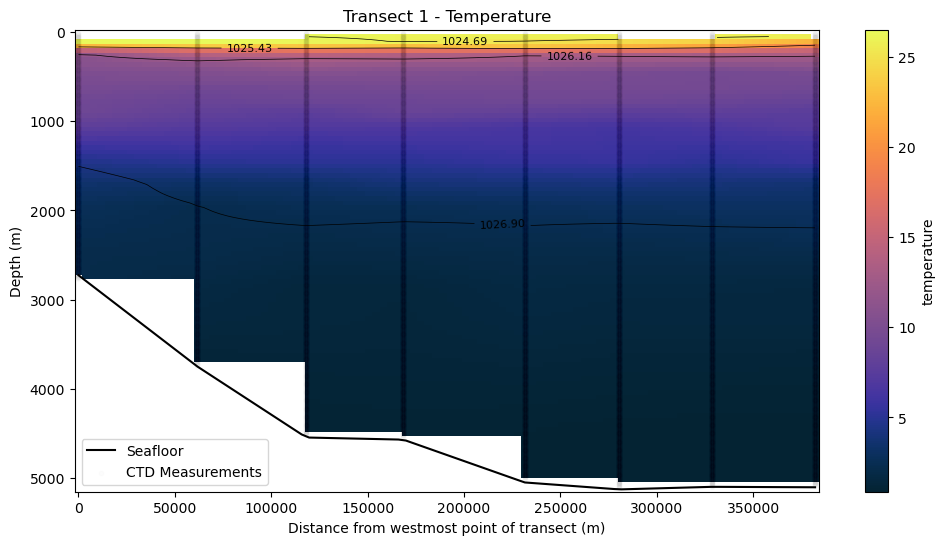

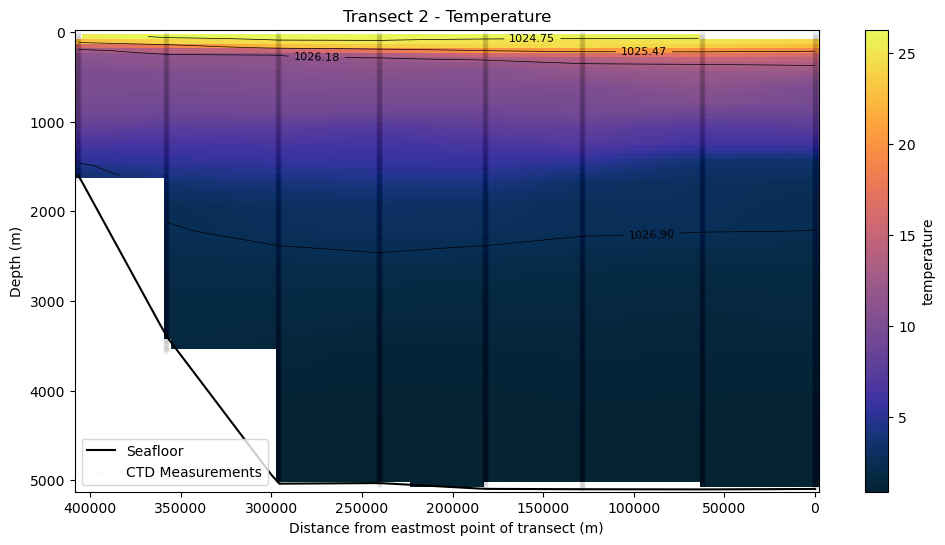

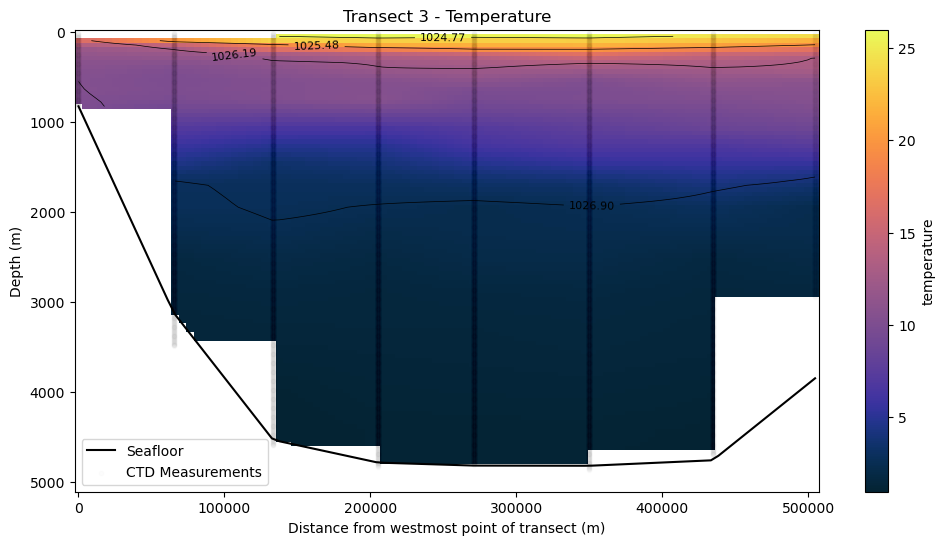

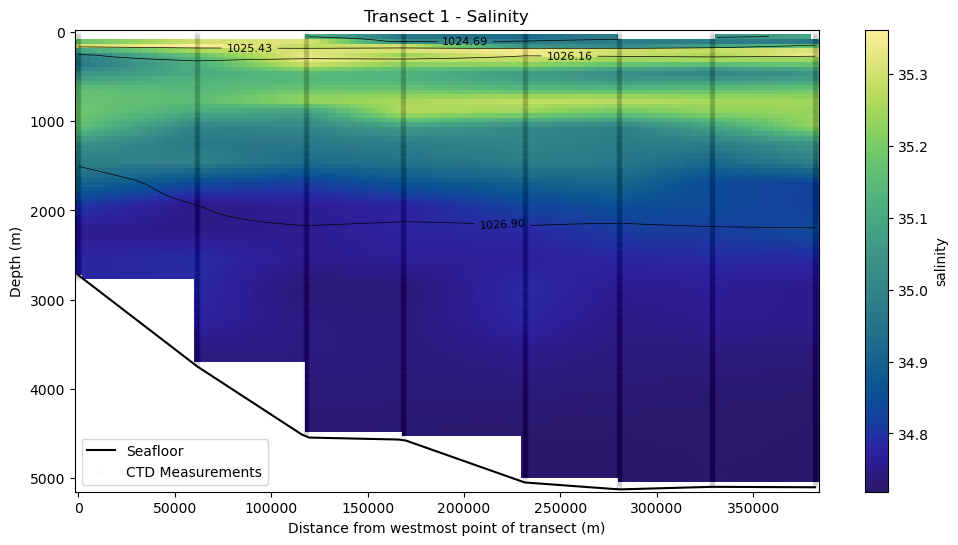

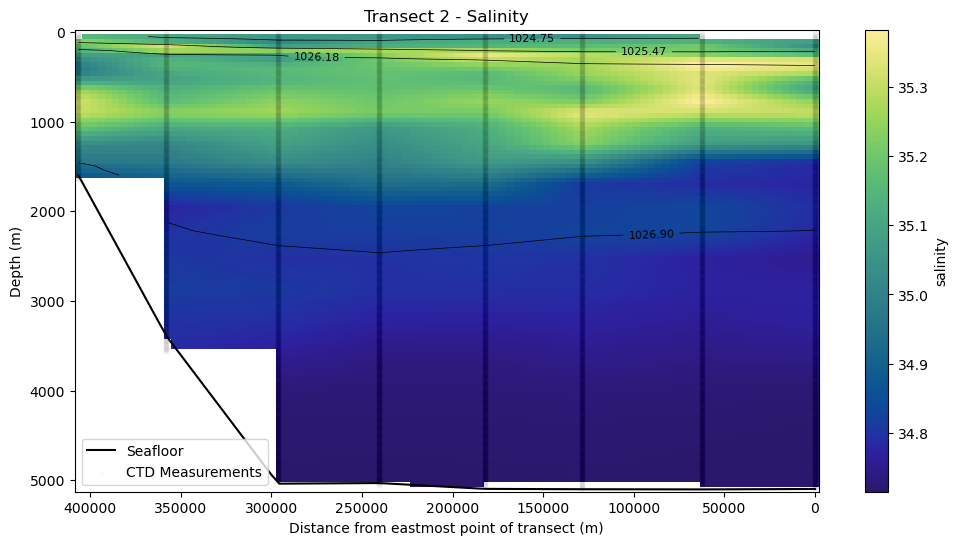

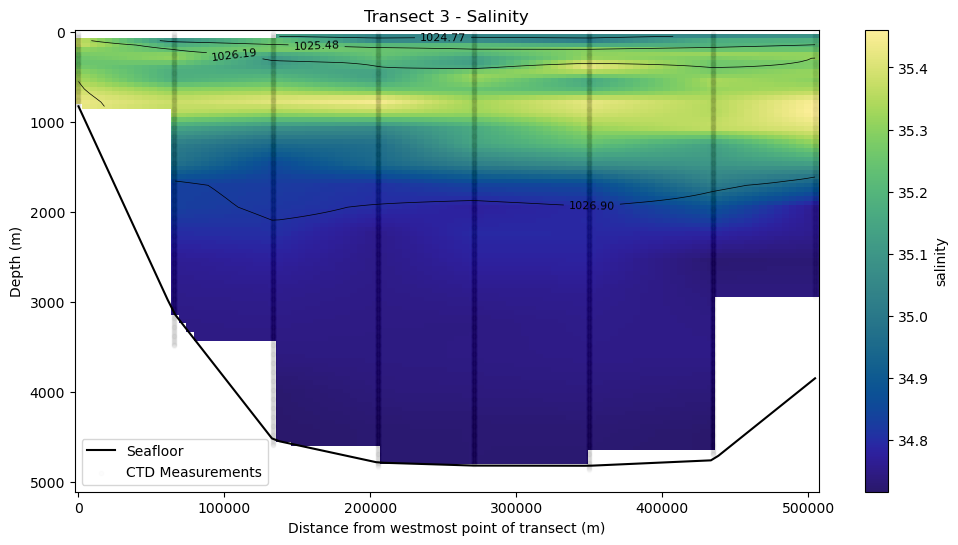

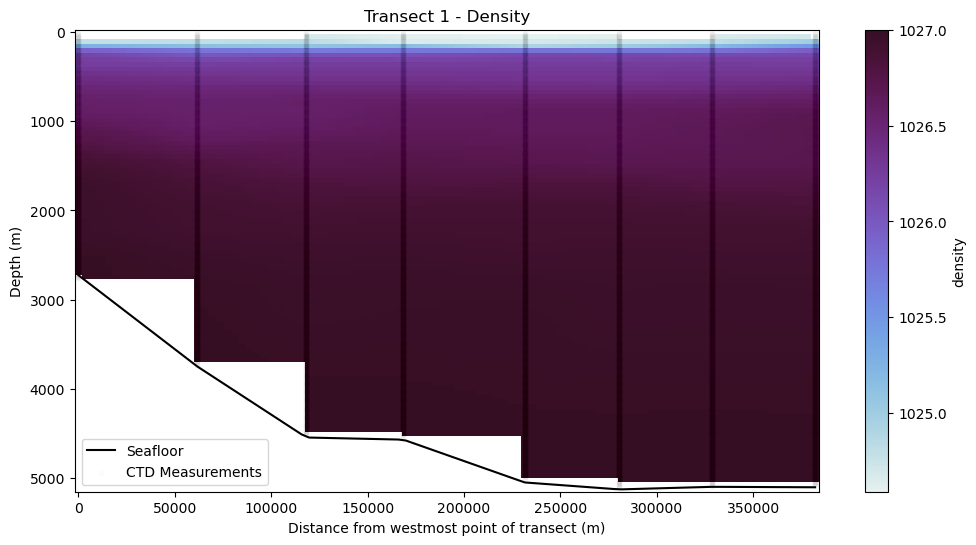

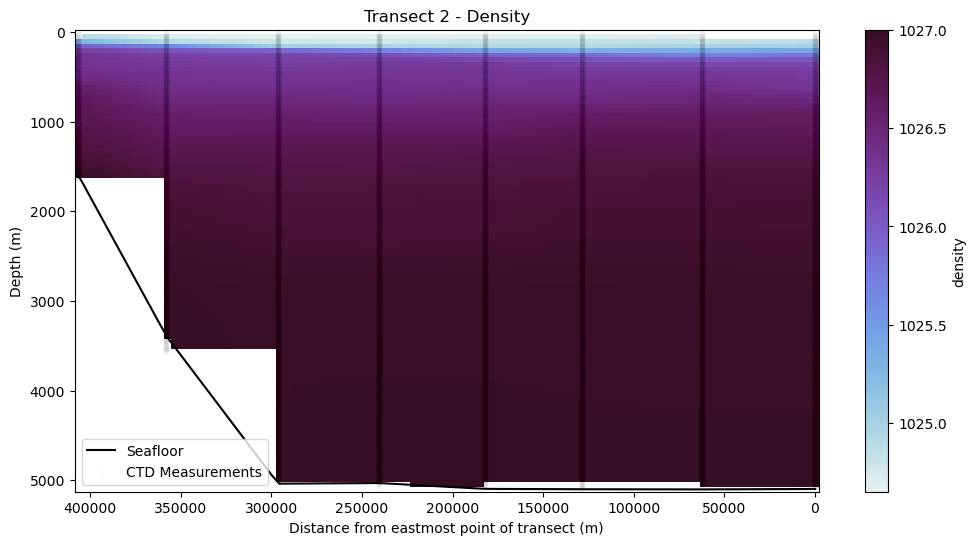

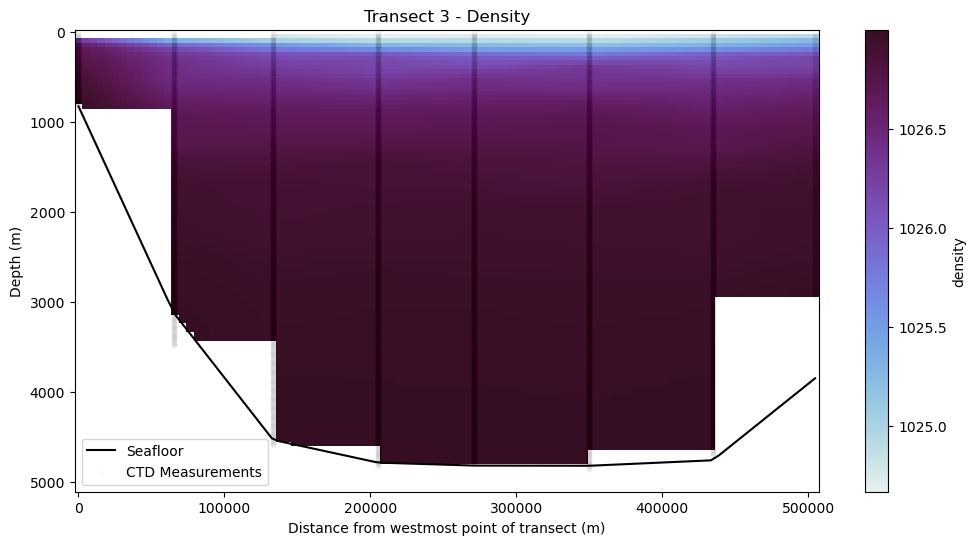

In [185]:
# First load your bathymetry data
bathy = xr.open_dataset(r"C:\Users\gvp63\Downloads\gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")

# Then plot cross-sections
transect_ids = [1, 2, 3]  # Your actual transect IDs
plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='temperature')
plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='salinity')
plot_transect_cross_sections(profiles, transect_ids, bathy, parameter='density')

In [155]:
from geopy.distance import geodesic
import numpy as np

# Constants
g = 9.81  # m/s²
rho0 = 1027  # Reference density (kg/m³)
f = 1e-4  # Coriolis parameter (adjust based on latitude)
reference_depth = 2000  # Depth of no motion (m)

# Group profiles by transect
transects = {}
for profile in profiles:
    transect_id = profile['transect_id']
    if transect_id not in transects:
        transects[transect_id] = []
    transects[transect_id].append(profile)

# Process each transect separately
for transect_id, transect_profiles in transects.items():
    print(f"\nProcessing Transect {transect_id}")
    
   # -------------------------------------------------------------------------
    # 1. Compute distances BETWEEN stations WITHIN TRANSECT
    # -------------------------------------------------------------------------
    dx_list = []
    for i in range(1, len(transect_profiles)):
        prev = transect_profiles[i-1]
        curr = transect_profiles[i]
        dx = geodesic((prev['lat'], prev['lon']), (curr['lat'], curr['lon'])).meters
        dx_list.append(dx)

    # Compute cumulative distance along transect (one value per station)
    x_transect = np.insert(np.cumsum(dx_list), 0, 0)

    # -------------------------------------------------------------------------
    # 3. Interpolate density to common depth grid
    # -------------------------------------------------------------------------
    density_interp = []
    for profile in transect_profiles:
        dens_interp = np.interp(common_depth, profile['depth'], profile['density'])
        density_interp.append(dens_interp)
    density_interp = np.array(density_interp)

    # -------------------------------------------------------------------------
    # 4. Thermal wind calculations (WITHIN TRANSECT)
    # -------------------------------------------------------------------------
    # Compute horizontal density gradient (∂ρ/∂x) using cumulative distances
    drho_dx = np.gradient(density_interp, x_transect, axis=0)
    print(transect_id, "gradient:", drho_dx)
    # Compute velocity shear (∂u/∂z)
    du_dz = (g / (rho0 * f)) * drho_dx

    # Integrate vertically to get velocity profile
    dz = np.gradient(common_depth)
    u = np.cumsum(du_dz * dz, axis=1)

    # -------------------------------------------------------------------------
    # 5. Reference velocity adjustment (per transect)
    # -------------------------------------------------------------------------
    ref_idx = np.argmin(np.abs(common_depth - reference_depth))
    u -= u[:, ref_idx:ref_idx+1]  # Subtract velocity at reference depth
    print(u[:, ref_idx:ref_idx+1])
    # -------------------------------------------------------------------------
    # 6. Transport calculation (per transect)
    # -------------------------------------------------------------------------
    # Integrate velocity over depth at each station
    transport_per_station = np.trapz(u, x=common_depth, axis=1)

    # Integrate transport across transect
    total_transport = np.trapz(transport_per_station, x=x_transect)

    print(f"Transect {transect_id} transport: {total_transport:.2f} m³/s")



Processing Transect 1
1 gradient: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.31550941e-11
  -1.00366736e-10 -8.61539749e-11 -5.06914218e-09 -1.32136555e-08
  -2.13531929e-08 -2.96425322e-08 -3.78313004e-08 -4.59581875e-08
  -5.40855554e-08 -6.77323486e-08 -9.38363780e-08 -1.19951140e-07
  -1.46844390e-07 -1.72979086e-07 -1.99084732e-07 -2.25175943e-07
  -2.72904061e-07 -3.51284947e-07 -4.29567780e-07 -5.08818818e-07
  -5.86985906e-07 -6.65201227e-07 -7.41090949e-07 -7.38168265e-07
  -7.29960199e-07 -7.22813638e-07 -7.14519431e-07 -7.06294395e-07
  -6.99541019e-07 -7.29312951e-07 -7.6135

C:\Users\gvp63\AppData\Local\Temp\ipykernel_9524\1262777043.py:67: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u, x=common_depth, axis=1)
C:\Users\gvp63\AppData\Local\Temp\ipykernel_9524\1262777043.py:70: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_transport = np.trapz(transport_per_station, x=x_transect)


In [186]:
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.interpolate import griddata
import cmocean  # Import cmocean for colormaps
import matplotlib.colors as mcolors  # Import mcolors for norm

def plot_transect_velocity_and_transport(profiles, transect_ids, bathy, n_interp=100):
    """
    Plot geostrophic velocity and transport for specified transects computed 
    from density profiles using the thermal wind balance, with bathymetry masking 
    and CTD measurement sites included.
    
    Parameters:
        profiles (list): List of profile dictionaries. Each must contain 
            'transect_id', 'lat', 'lon', 'depth', and 'density'.
        transect_ids (list): List of transect IDs to plot.
        bathy: Bathymetry dataset with an 'elevation' variable.
        n_interp (int): Number of interpolation points along the transect.
    """
    # --- Constants for thermal wind calculation ---
    g = 9.81         # gravitational acceleration (m/s²)
    rho0 = 1027      # reference density (kg/m³)
    f = 1e-4         # Coriolis parameter (s⁻¹)
    reference_depth = 2000  # reference depth (m) for zero velocity
    norm = mcolors.CenteredNorm(vcenter=0, halfrange=0.8)  # halfrange=1 makes range [-1, 1]
    cmap = cmocean.cm.balance

    # --- Determine a common depth grid spanning from the surface to maximum measured depth ---
    valid_profiles = [p for p in profiles if len(p['depth']) > 0]
    if not valid_profiles:
        print("No valid profiles with non-empty depth arrays.")
        return
    
    # Use full depth range from the surface (0 m) to the maximum measured depth across profiles
    max_depth = max([np.max(np.abs(p['depth'])) for p in valid_profiles])
    common_z = np.linspace(0, max_depth, 100)
    
    for transect_id in transect_ids:
        transect_profiles = [p for p in profiles if p['transect_id'] == transect_id]
        
        # Reverse station order for east-west transects (e.g., Transect 2)
        if transect_id == 2:
            transect_profiles = transect_profiles[::-1]  # Reverse the list

        # Recompute distances after reversing
        distances = [0]
        for i in range(1, len(transect_profiles)):
            prev = (transect_profiles[i-1]['lat'], transect_profiles[i-1]['lon'])
            curr = (transect_profiles[i]['lat'], transect_profiles[i]['lon'])
            distances.append(distances[-1] + geodesic(prev, curr).meters)

        # Filter profiles for the current transect
        if not transect_profiles:
            print(f"No profiles found for transect {transect_id}. Skipping.")
            continue
        
        # --- Compute cumulative distances along the transect ---
        distances = [0]
        for i in range(1, len(transect_profiles)):
            prev = (transect_profiles[i-1]['lat'], transect_profiles[i-1]['lon'])
            curr = (transect_profiles[i]['lat'], transect_profiles[i]['lon'])
            distances.append(distances[-1] + geodesic(prev, curr).meters)
        x_transect = np.array(distances)
        
        # --- Compute bathymetry (seafloor depth) at each station ---
        station_bathy = []
        for p in transect_profiles:
            lon = p['lon']
            lat = p['lat']
            elev = bathy.elevation.sel(lon=lon, lat=lat, method="nearest").values
            # Convert elevation to positive depth (if elevation is negative, that means depth)
            station_bathy.append(-elev if elev < 0 else elev)
        station_bathy = np.array(station_bathy)
        
        # Interpolate the station bathymetry onto a uniform horizontal grid
        xi = np.linspace(0, distances[-1], n_interp)
        bathy_interp = np.interp(xi, x_transect, station_bathy)
        
        # --- Interpolate density profiles onto the common depth grid ---
        density_interp = []
        for p in transect_profiles:
            if len(p['depth']) == 0:
                print(f"Skipping station in transect {transect_id} due to empty depth array.")
                continue
            # Ensure depths are positive and sort the arrays
            depths = np.abs(p['depth'])
            order = np.argsort(depths)
            depths_sorted = np.array(depths)[order]
            dens_sorted = np.array(p['density'])[order]
            # Extrapolate by extending the boundary values so the entire grid gets filled
            dens_interp = np.interp(common_z, depths_sorted, dens_sorted,
                                    left=dens_sorted[0], right=dens_sorted[-1])
            density_interp.append(dens_interp)
        if len(density_interp) == 0:
            print(f"No valid density data for transect {transect_id}. Skipping.")
            continue
        density_interp = np.array(density_interp)
        
        if len(x_transect) != density_interp.shape[0]:
            print(f"Mismatch in profiles and distances for transect {transect_id}. Skipping.")
            continue
        
        # --- Compute horizontal density gradient along the transect ---
        drho_dx = np.gradient(density_interp, x_transect, axis=0)
        
        # --- Compute vertical gradient in depth ---
        dz = np.gradient(common_z)
        
        # --- Thermal wind: compute vertical shear and integrate in depth ---
        du_dz = (g / (rho0 * f)) * drho_dx
        u = np.cumsum(du_dz * dz, axis=1)
        # Adjust velocity so that it is zero at the reference depth
        ref_idx = np.argmin(np.abs(common_z - reference_depth))
        u = u - u[:, ref_idx:ref_idx+1]
        
        # --- Prepare a uniform grid for plotting the velocity section ---
        xi_grid, zi_grid = np.meshgrid(xi, common_z)
        
        # Create arrays of original data points (each station's x repeated for every depth)
        x_points = np.repeat(x_transect, len(common_z))
        z_points = np.tile(common_z, len(transect_profiles))
        velocities_flat = u.flatten()
        
        # Grid the computed velocities onto the uniform grid
        velocity_grid = griddata((x_points, z_points), velocities_flat,
                                 (xi_grid, zi_grid), method='linear')
        
        # --- Mask grid cells below the seafloor ---
        velocity_grid_masked = np.where(zi_grid > bathy_interp, np.nan, velocity_grid)
        
        # --- Plot the geostrophic velocity section ---
        plt.figure(figsize=(10, 6))
        pcm = plt.pcolormesh(xi_grid, common_z, velocity_grid_masked,
                             cmap=cmap, norm=norm, shading='auto')
        plt.colorbar(pcm, label='Geostrophic Velocity (m/s)')
        
        # Customize x-axis label for Transect 2
        if transect_id == 2:
            xlabel = 'Distance from eastmost point of transect (m)'
        else:
            xlabel = 'Distance from westmost point of transect (m)'
        plt.xlabel(xlabel)
        
        plt.ylabel('Depth (m)')
        plt.title(f'Transect {transect_id} - Geostrophic Velocity Section')
        
        # Plot the seafloor line using the uniform grid
        plt.plot(xi, bathy_interp, 'k-', linewidth=1.5, label='Seafloor')
        
        # --- Plot CTD measurement sites ---
        meas_x = []
        meas_y = []
        for distance, p, station_depth in zip(x_transect, transect_profiles, station_bathy):
            depths = np.abs(p['depth'])
            # Include only measurements above the seafloor at that station
            valid = depths <= station_depth
            if np.any(valid):
                meas_x.extend(np.repeat(distance, np.sum(valid)))
                meas_y.extend(depths[valid])
        plt.scatter(meas_x, meas_y, c='k', alpha=0.01, s=10, label='CTD Measurements')
        
        # Invert y-axis so that shallow depths appear at the top
        if transect_id == 2:
            plt.gca().invert_xaxis()  # Invert x-axis for Transect 2
        plt.gca().invert_yaxis()
        plt.legend()
        plt.show()
        
        # --- Calculate transport ---
        transport_per_station = np.trapz(u, x=common_z, axis=1)
        total_transport = np.trapz(transport_per_station, x=x_transect)
        
        # --- Plot transport per station along the transect ---
        plt.figure(figsize=(8, 5))
        plt.plot(x_transect, transport_per_station, 'o-', label='Transport per Station')
        
        # Customize x-axis label for Transect 2
        if transect_id == 2:
            xlabel = 'Distance from eastmost point of transect (m)'
        else:
            xlabel = 'Distance from westmost point of transect (m)'
        plt.xlabel(xlabel)
        
        plt.ylabel('Transport per Station (m³/s)')
        plt.title(f'Transect {transect_id}\nTotal Transport = {total_transport:.2f} m³/s')
        plt.grid(True)
        plt.legend()
        plt.show()

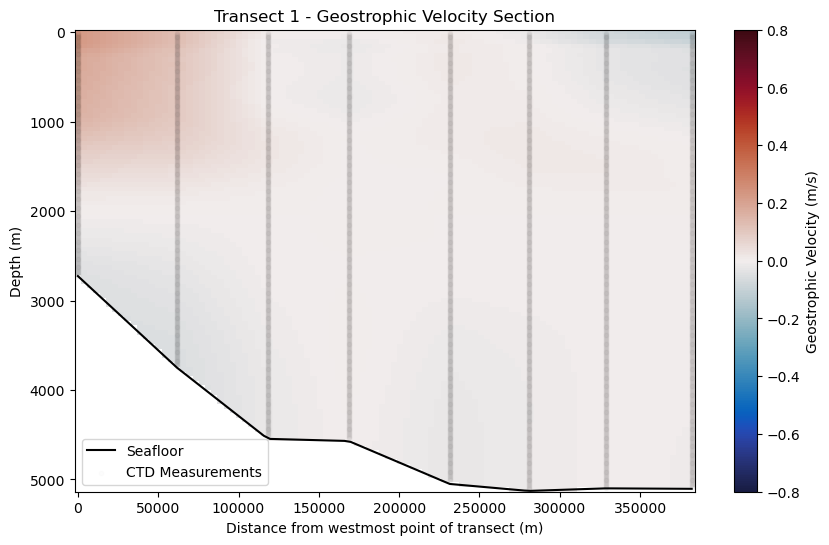

C:\Users\gvp63\AppData\Local\Temp\ipykernel_9524\1473834643.py:171: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u, x=common_z, axis=1)
C:\Users\gvp63\AppData\Local\Temp\ipykernel_9524\1473834643.py:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_transport = np.trapz(transport_per_station, x=x_transect)


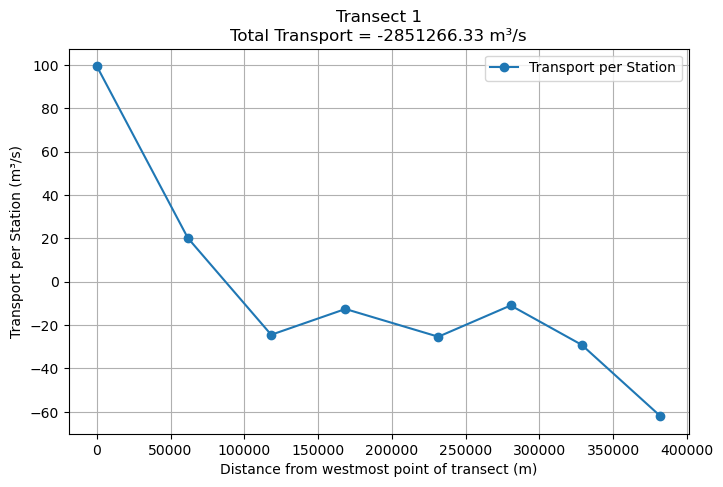

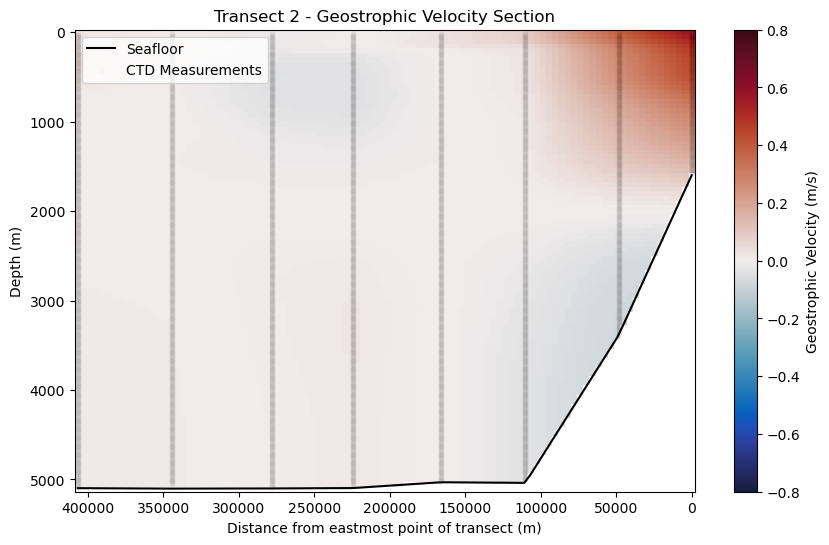

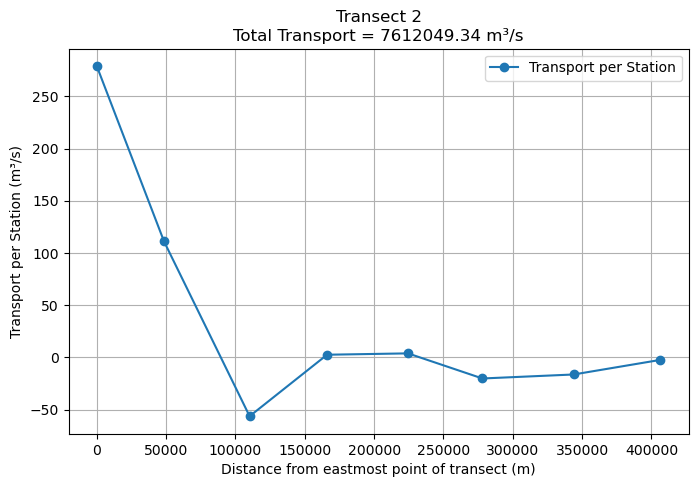

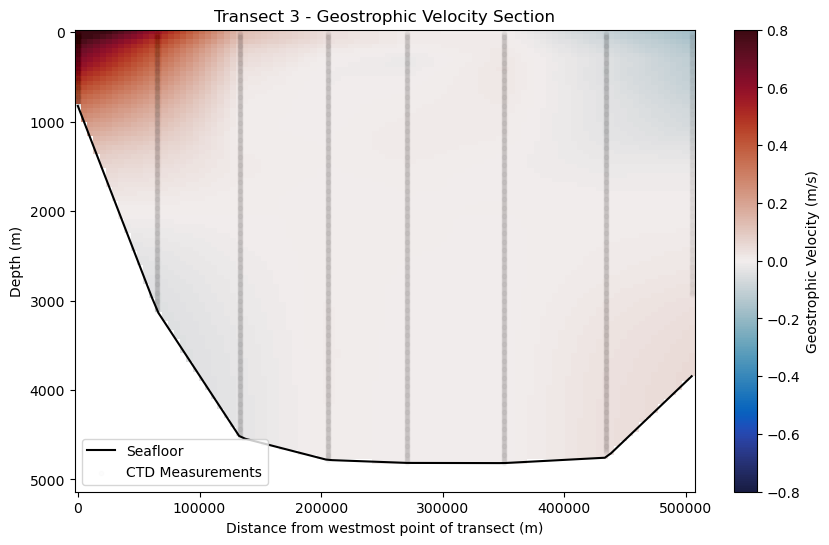

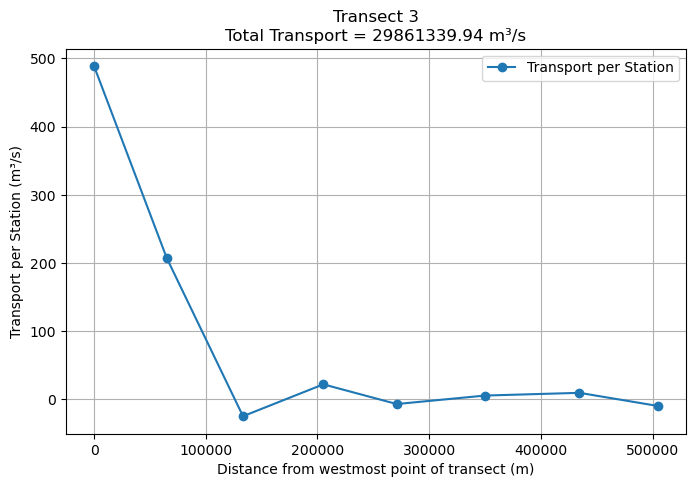

In [187]:
# Example usage:
# Your profiles should include the keys: 'transect_id', 'lat', 'lon', 'depth', 'density'
transect_ids = [1, 2, 3]  # Replace with your actual transect IDs
plot_transect_velocity_and_transport(profiles, transect_ids, bathy)


c:\Users\gvp63\anaconda3\envs\dyoc\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


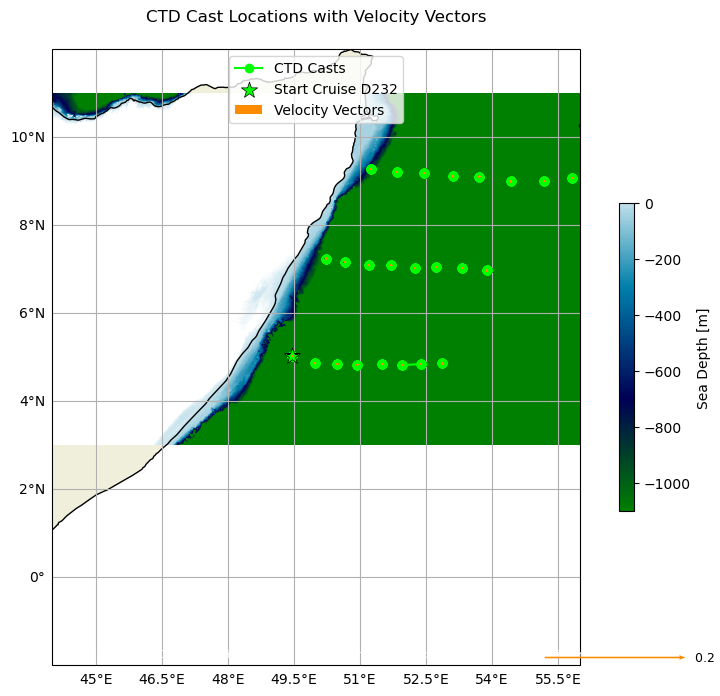

In [188]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load bathymetry data
bathy = xr.open_dataset(r"C:\Users\gvp63\Downloads\gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot bathymetry
tp = ax.pcolormesh(bathy.lon, bathy.lat, bathy.elevation, cmap='ocean',
                   vmin=-1100, vmax=100, transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.gridlines(draw_labels=['left', 'bottom'], zorder=0)

# Plot CTD cast locations
if data:
    # Plot cruise track
    lons = [profile['lon'] for profile in data]
    lats = [profile['lat'] for profile in data]
    ax.plot(lons, lats, '-o', transform=ccrs.PlateCarree(),
            c='lime', label='CTD Casts')
    ax.scatter(lons[0], lats[0], c='lime', marker='*', s=150, zorder=2,
               transform=ccrs.PlateCarree(), edgecolors='k', linewidths=0.5,
               label='Start Cruise D232')
    
    # --- Improved velocity vectors ---
    velocities = np.array([profile.get('velocity', 0) for profile in data])
    
    # Vector scaling parameters
    scale_factor = 2e5  # Adjusted for better visual scaling
    vector_scale = 1.5e5  # Lower number = larger arrows
    arrow_width = 0.003
    arrow_scale = 50  # Arrows per data unit (higher = smaller arrows)
    
    # Create vectors (east component = 0 for purely alongshore flow)
    u = np.zeros_like(velocities)
    v = velocities * scale_factor
    
    # Plot vectors with improved styling
    q = ax.quiver(lons, lats, u, v, transform=ccrs.PlateCarree(),
                  color='darkorange', scale=vector_scale, width=arrow_width,
                  headwidth=3, headlength=4, headaxislength=3.5, zorder=3,
                  label='Velocity Vectors')

    # Add vector scale legend
    ax.quiverkey(q, 0.85, 0.12, 0.2*scale_factor, 
                 "0.2 m/s", labelpos='E', coordinates='figure',
                 fontproperties={'size': 9}, color='darkorange')

    ax.legend(loc='upper center')
else:
    print("Warning: No CTD data found. Skipping CTD cast locations.")

# Set title and extent
ax.set_title('CTD Cast Locations with Velocity Vectors', pad=20)
ax.set_extent([44, 56, -2, 12])  # [min_lon, max_lon, min_lat, max_lat]

# Add colorbar
cb = fig.colorbar(tp, ax=ax, shrink=0.5)
cb.ax.set_ylim([-1100, 0])
cb.set_label('Sea Depth [m]')

# Add source text
info_text = bathy.attrs.get('title', 'GEBCO 2024 Grid')
ax.text(0.01, 0.01, info_text, transform=ax.transAxes, 
        fontsize=8, color='white', ha='left', va='bottom')

plt.show()
